# **Boston Crime Analysis**

##### We are using crimes in Boston data set to analyze where and when the crimes happened. Data contains information about the crimes that have happened over 4 years. This data can be used to predict the possible crimes that can happen in the future. We are analyzing the data by plotting graph for various attributes. 

Features:

INCIDENT_NUMBER: The id of the crime committed. It is unique value for each crime.

OFFENSE_CODE: It shows code of crime types.

OFFENSE_CODE_GROUP: General crime types.

OFFENSE_DESCRIPTION: Detailed explanation of the crime.

DISTRICT: District name where the crime occurred.

REPORTING_AREA: Area number that crime reported.

SHOOTING: It shows with 'Y', if the crime included shooting.

OCCURRED_ON_DATE: the date& time that crime occured.

YEAR: the year that crime occured. (2015,2016,2017,2018)

MONTH: the month that crime occured.

DAY OF WEEK: the week that crime occured.

HOUR: the hour that crime occured.

UCR_PART: Uniform Crime Reporting Offence types. Part 1 contains the most dangerous and important crimes.

STREET: the street where crime occured.

LAT: the latitude where the crime occurred.

LONG: the longitude where the crime occurred.

LOCATION: the location where the crime occurred.(include latitude and longitude)

                                        DataBase Schema

In [179]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import csv

filename='crime.csv'
df_1 = pd.read_csv('crime.csv',encoding='ISO-8859-1')
df_2 = pd.read_csv('offense_codes.csv',encoding='ISO-8859-1')
conn =sqlite3.connect('non_norm_prj_data.db')
cur=conn.cursor()

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

conn =sqlite3.connect('non_norm_prj_data.db')
cur = conn.cursor()
cur.execute('''DROP TABLE IF EXISTS crime''')
cur.execute('''DROP TABLE IF EXISTS offense_codes''')
df_1.to_sql('crime', conn, if_exists='replace', index=False) # - writes the pd.df to SQLIte DB
df_2.to_sql('offense_codes', conn, if_exists='replace', index=False) # - writes the pd.df to SQLIte DB
conn.commit()


                                                Offense Table

In [ ]:
#Creating offense table
sql_statement = "SELECT DISTINCT(OFFENSE_DESCRIPTION),OFFENSE_CODE,OFFENSE_CODE_GROUP from crime"
off_cd = execute_sql_statement(sql_statement, conn)

create_table_sql = """CREATE TABLE [offense_codes] (
     [OFFENSE_CODE] INTIGER NOT NULL,
     [OFFENSE_CODE_GROUP] TEXT,
     [OFFENSE_DESCRIPTION] TEXT
 );
 """
def insert_offense_codes(conn, values):
    sql = ''' INSERT INTO offense_codes(OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION)
            VALUES(?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

off_cd = sorted(off_cd, key = lambda x : x[1])
print(off_cd[1])
conn_norm = create_connection('norm_prj_data.db')
create_table(conn_norm, create_table_sql,'offense_codes')
tpl=()
with conn_norm:
    for i in off_cd:
        tpl=(i[1],i[2],i[0])
        insert_offense_codes(conn_norm,tpl)


                                            Week_Days and Months Table

In [181]:
#Creating week days  table
months = {1 : 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct',11: 'Nov', 12: 'Dec'}
months = list(months.items())
week_rows = execute_sql_statement("select distinct DAY_OF_WEEK from crime;", conn)

create_table(conn_norm,"""create table if not exists Week_days(
    [Week_id] INTIGER not null primary key,
    [Week] INTIGER
)""")

create_table(conn_norm,"""create table if not exists Months(
    [Month_id] INTIGER not null primary key,
    [Month] INTIGER not null
)
""")

week_rows = [tuple([i+1] + [week_rows[i][0]]) for i in range(len(week_rows))]
conn_norm = create_connection('norm_prj_data.db')
cur_norm = conn_norm.cursor()
cur_norm.executemany("insert or ignore into Week_days values(?, ?)", week_rows)
cur_norm.executemany("insert or ignore into Months values(?, ?)", months)
conn_norm.commit()


In [182]:
week_list = execute_sql_statement("select * from Week_days;", conn_norm)
week_dict = {key: value for value, key in week_list}
week_dict

{'Sunday': 1,
 'Tuesday': 2,
 'Monday': 3,
 'Saturday': 4,
 'Friday': 5,
 'Wednesday': 6,
 'Thursday': 7}

                                        Crimes in Boston Table

In [183]:
#Creating crimes in boston table
create_Crimes_in_Boston = """create table BostonCrimes(
    [INCIDENT_NUMBER] text not null primary key,
    [OFFENSE_CODE] integer not null,
    [DISTRICT] text not null,
    [REPORTING_AREA] integer not null,
    [OCCURRED_ON_DATE] text not null,
    [YEAR] integer not null,
    [Month_id] integer not null,
    [Week_id] integer not null,
    [HOUR] integer not null,
    [UCR_PART] text not null,
    [LATITUDE] real not null,
    [LONGITUDE] real not null,
    foreign key(Month_id) references Months(Month_id),
    foreign key(Week_id) references Week_days(Week_id)
)
"""
create_table(conn_norm, create_Crimes_in_Boston, drop_table_name=True)

table BostonCrimes already exists


In [184]:
crime_rows = execute_sql_statement("select * from crime;", conn)
boston_crime_data = []
for item in crime_rows:
    boston_crime_data.append((item[0], item[1], item[4], item[5], item[7], int(item[8]), int(item[9]), week_dict[item[10]], int(item[11]), item[12], item[14],item[15]))
cur_norm.executemany("insert or ignore into BostonCrimes values(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", boston_crime_data)
conn_norm.commit()

In [185]:
rows_data = execute_sql_statement("select * from BostonCrimes;", conn_norm)
rows_data = pd.DataFrame(rows_data)
rows_data

,0,1,2,3,4,5,6,7,8,9,10,11
0,I182070945,619,D14,808,2018-09-02 13:00:00,2018,9,1,13,Part One,42.357791,-71.139371
1,I182070943,1402,C11,347,2018-08-21 00:00:00,2018,8,2,0,Part Two,42.306821,-71.060300
2,I182070941,3410,D4,151,2018-09-03 19:27:00,2018,9,3,19,Part Three,42.346589,-71.072429
3,I182070940,3114,D4,272,2018-09-03 21:16:00,2018,9,3,21,Part Three,42.334182,-71.078664
4,I182070938,3114,B3,421,2018-09-03 21:05:00,2018,9,3,21,Part Three,42.275365,-71.090361
...,...,...,...,...,...,...,...,...,...,...,...,...
263933,I060168073-00,1864,E13,912,2018-01-27 14:01:00,2018,1,4,14,Part Two,42.322838,-71.100967
263934,I050310906-00,3125,D4,285,2016-06-05 17:25:00,2016,6,1,17,Part Three,42.336951,-71.085748
263935,I030217815-08,111,E18,520,2015-07-09 13:38:00,2015,7,7,13,Part One,42.255926,-71.123172
263936,I010370257-00,3125,E13,569,2016-05-31 19:35:00,2016,5,2,19,Part Three,42.302333,-71.111565


                                         Data Visualisation

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns

                                        Count of Crimes per each year

In [187]:
#Count of the crimes in each year
rows_data = execute_sql_statement("select YEAR, count(YEAR) from BostonCrimes group by YEAR;", conn_norm)
rows_data = pd.DataFrame(rows_data)
rows_data.columns = ["YEAR", "Count_per_year"]
rows_data

,YEAR,Count_per_year
0,2015,45091
1,2016,81630
2,2017,82986
3,2018,54231


Text(0.5, 1.0, 'Number Of Crimes for Each Year')

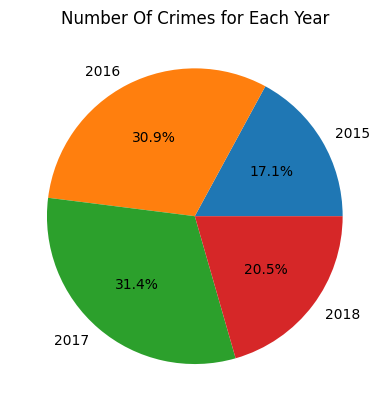

In [188]:
plt.pie(rows_data['Count_per_year'], labels=rows_data['YEAR'], autopct='%1.1f%%')
plt.title('Number Of Crimes for Each Year')

                                        Count of Crimes on different days of a week

In [189]:
#Count of crimes in the days in a week.
rows_data = execute_sql_statement("select Week_days.Week, count(INCIDENT_NUMBER) from BostonCrimes join Week_days on Week_days.Week_id = BostonCrimes.Week_id group by Week_days.Week;", conn_norm)
rows_data = pd.DataFrame(rows_data)
rows_data.columns = ["Week_day", "Count_per_weekday"]
rows_data

,Week_day,Count_per_weekday
0,Friday,40058
1,Monday,37933
2,Saturday,36915
3,Sunday,33696
4,Thursday,38428
5,Tuesday,38256
6,Wednesday,38652


Text(0.5, 1.0, 'Number Of Crimes Each Day of Week')

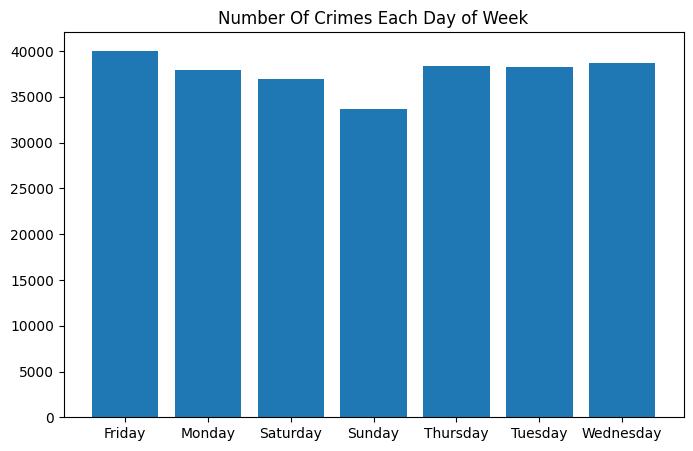

In [190]:
plt.figure(figsize=(8, 5))
plt.bar(height=rows_data['Count_per_weekday'], x = rows_data['Week_day'])
plt.title('Number Of Crimes Each Day of Week')

                                        Count of Crimes per Month

In [191]:
#Count of crimes by month
rows_data = execute_sql_statement("select Months.Month, count(INCIDENT_NUMBER) from BostonCrimes join Months on Months.Month_id = BostonCrimes.Month_id group by Months.Month order by Months.Month_id;", conn_norm)
rows_data = pd.DataFrame(rows_data)
rows_data.columns = ["Month", "Count_of_Crimes_per_month"]
rows_data

,Month,Count_of_Crimes_per_month
0,Jan,19705
1,Feb,17792
2,Mar,19834
3,Apr,19993
4,May,21687
5,Jun,25351
6,Jul,28406
7,Aug,28797
8,Sep,21917
9,Oct,21183


Text(0.5, 1.0, 'Number Of Crimes per Each Month of each year')

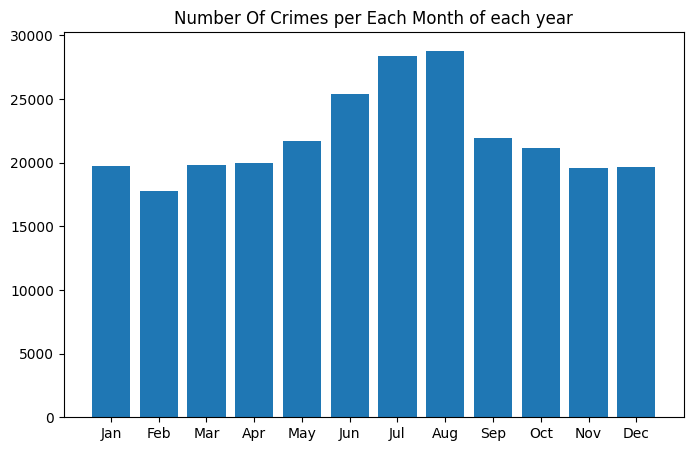

In [192]:
plt.figure(figsize=(8, 5))
plt.bar(height=rows_data['Count_of_Crimes_per_month'], x = rows_data['Month'])
plt.title('Number Of Crimes per Each Month of each year')

                                     Count of Crimes per each hour in a day

In [193]:
#Getting the crimes data by hour
rows_data = execute_sql_statement("select HOUR + 1, count(INCIDENT_NUMBER) from BostonCrimes group by HOUR;", conn_norm)
rows_data = pd.DataFrame(rows_data)
rows_data.columns = ["Hours", "Count_of_Crimes_per_hour"]
rows_data

,Hours,Count_of_Crimes_per_hour
0,1,12309
1,2,7015
2,3,5890
3,4,3624
4,5,2698
5,6,2722
6,7,4145
7,8,7595
8,9,11023
9,10,12659


Text(0.5, 1.0, 'Number Of Crimes per Each hour of a day')

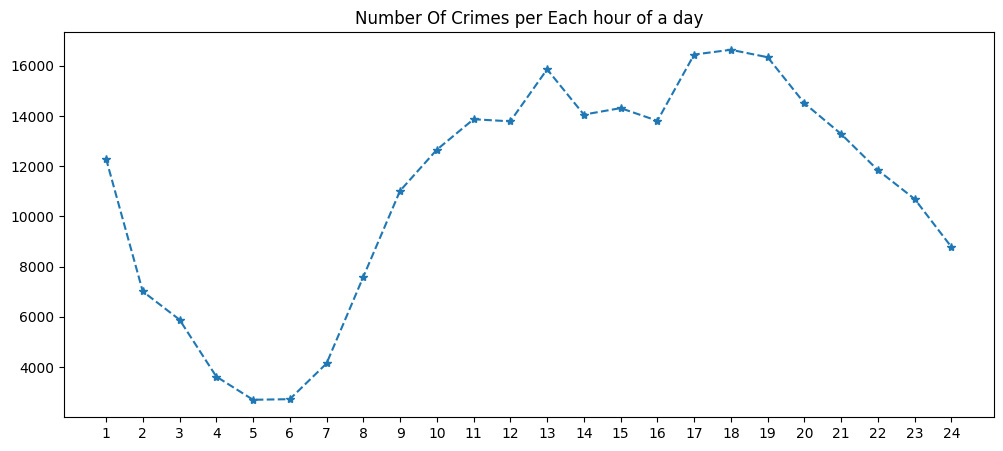

In [194]:
plt.figure(figsize=(12, 5))
plt.plot(rows_data['Hours'], rows_data['Count_of_Crimes_per_hour'], marker='*', linestyle='--')
plt.xticks(rows_data['Hours'])
plt.title('Number Of Crimes per Each hour of a day')

                                        Count of Crimes in each District

In [195]:
#Count of crime by district 
rows_data = execute_sql_statement("select DISTRICT, count(INCIDENT_NUMBER) from BostonCrimes group by DISTRICT;", conn_norm)
rows_data = pd.DataFrame(rows_data)
rows_data.columns = ["District", "Count_of_Crimes_in_dristrict"]
rows_data

,District,Count_of_Crimes_in_dristrict
0,A1,28032
1,A15,5676
2,A7,11859
3,B2,40253
4,B3,29680
5,C11,35931
6,C6,19677
7,D14,17660
8,D4,33709
9,E13,14832


Text(0.5, 1.0, 'Number Of Crimes in each District')

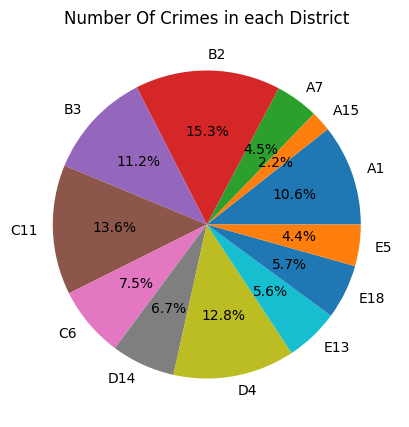

In [196]:
plt.figure(figsize=(12, 5))
plt.pie(rows_data['Count_of_Crimes_in_dristrict'], labels=rows_data['District'], autopct='%1.1f%%')
plt.title('Number Of Crimes in each District')


                                    Count of Crimes by month for all 4 different years

In [197]:
#Counting the crimes by month for all 4 years
rows_data = execute_sql_statement("select Months.Month, BostonCrimes.YEAR, BostonCrimes.INCIDENT_NUMBER from BostonCrimes join Months on Months.Month_id = BostonCrimes.Month_id", conn_norm)
rows_data = pd.DataFrame(rows_data)
rows_data.columns = ["Month", "Year", "Incident_Number"]
rows_data

,Month,Year,Incident_Number
0,Sep,2018,I182070945
1,Aug,2018,I182070943
2,Sep,2018,I182070941
3,Sep,2018,I182070940
4,Sep,2018,I182070938
...,...,...,...
263933,Jan,2018,I060168073-00
263934,Jun,2016,I050310906-00
263935,Jul,2015,I030217815-08
263936,May,2016,I010370257-00


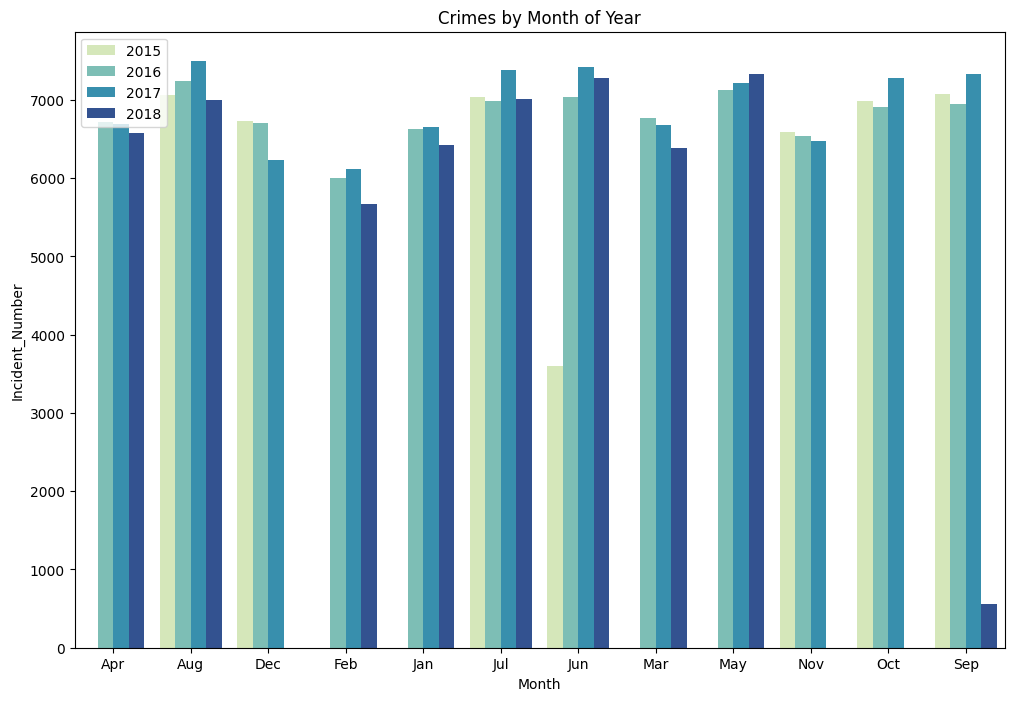

In [198]:
fig, ax = plt.subplots(figsize=(12,8))
mont_year_Aggregated = pd.DataFrame(rows_data.groupby(["Month","Year"])["Incident_Number"].count()).reset_index()
a=sns.barplot(data=mont_year_Aggregated,x="Month", y="Incident_Number",hue = 'Year', palette='YlGnBu')
a.set_title("Crimes by Month of Year",fontsize=12)
plt.legend(loc='upper left')
plt.show()


                                    Count of Crimes based on location in each district

In [199]:
#getting crimes data based on the location by district
rows_data = execute_sql_statement("select LATITUDE, LONGITUDE, DISTRICT from BostonCrimes", conn_norm)
rows_data = pd.DataFrame(rows_data)
rows_data.columns = ["Lat", "Long", 'District']
rows_data

,Lat,Long,District
0,42.357791,-71.139371,D14
1,42.306821,-71.060300,C11
2,42.346589,-71.072429,D4
3,42.334182,-71.078664,D4
4,42.275365,-71.090361,B3
...,...,...,...
263933,42.322838,-71.100967,E13
263934,42.336951,-71.085748,D4
263935,42.255926,-71.123172,E18
263936,42.302333,-71.111565,E13


<AxesSubplot: xlabel='Lat', ylabel='Long'>

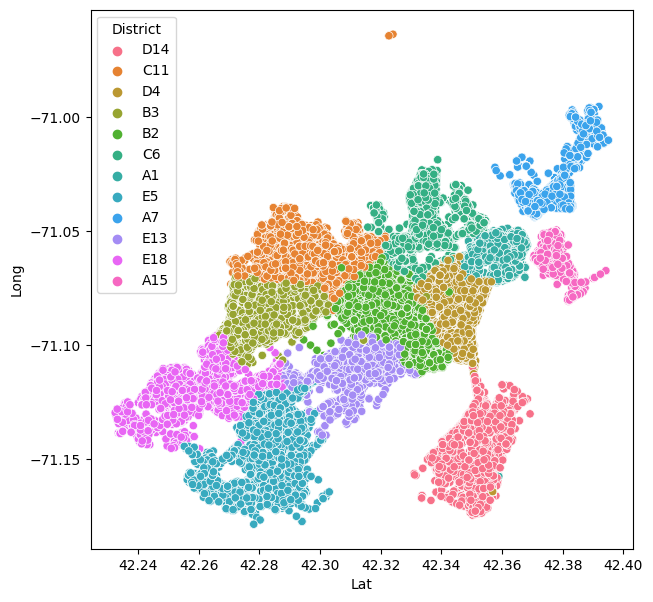

In [200]:
plt.figure(figsize=(7,7))
spacial_points = rows_data[(rows_data['Lat'] != -1) & (rows_data['Long'] != -1)]
sns.scatterplot(x="Lat", y="Long",hue='District',data=spacial_points)

                                        Count of Crimes by each offense group

In [201]:
#Number of Crimes Per Each Offense Group
rows_data = execute_sql_statement("select OFFENSE_CODE_GROUP, count(INCIDENT_NUMBER) from offense_codes join BostonCrimes on Offense_Codes.Offense_Code = BostonCrimes.Offense_Code Group BY(OFFENSE_CODE_GROUP)", conn_norm)
rows_data = pd.DataFrame(rows_data)
rows_data.columns = ['Offense_Code_Group','Count_Of_Crimes_Per_Each_Group']
rows_data

,Offense_Code_Group,Count_Of_Crimes_Per_Each_Group
0,Aggravated Assault,12284
1,Aircraft,30
2,Arson,77
3,Assembly or Gathering Violations,870
4,Auto Theft,4356
...,...,...
59,Towed,10325
60,Vandalism,13182
61,Verbal Disputes,12432
62,Violations,3324


Text(0.5, 1.0, 'Number Of Crimes per Each Offense Code Group')

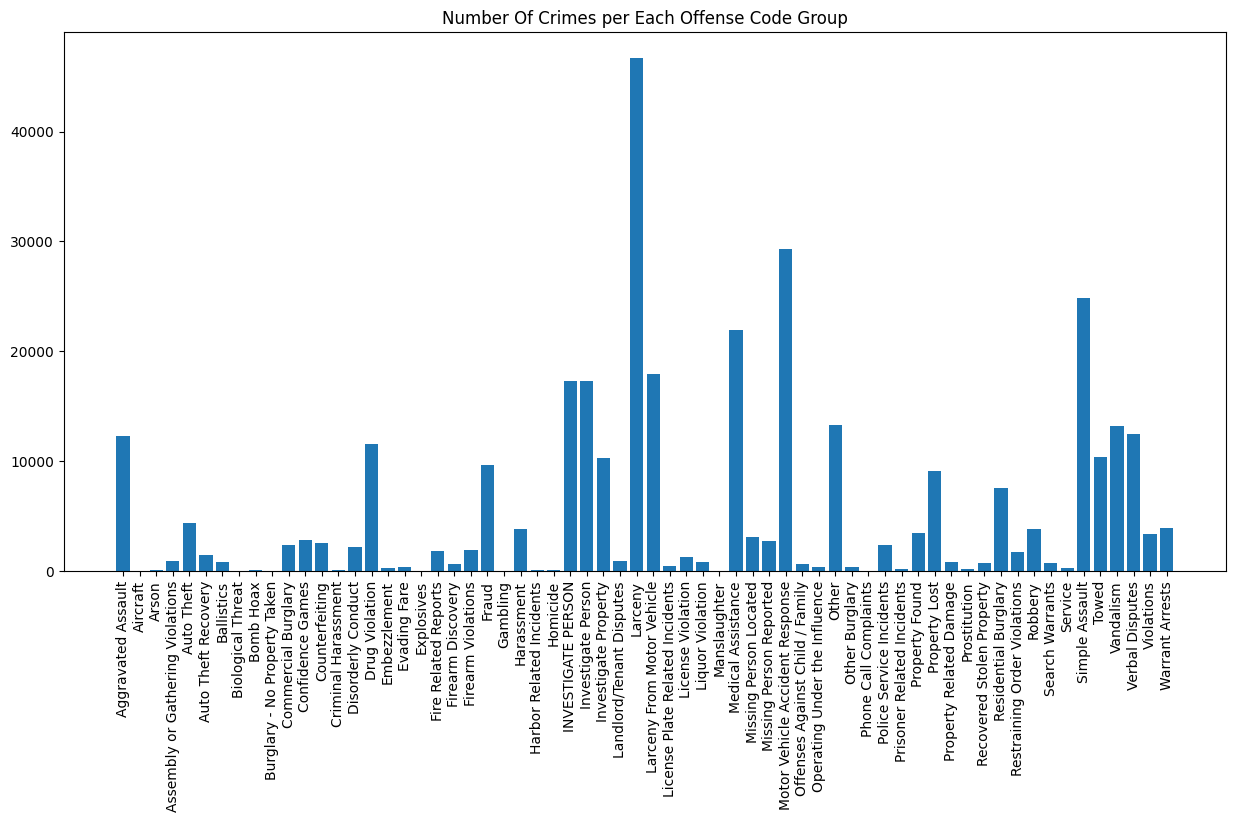

In [202]:
plt.figure(figsize=(15, 7))
plt.bar(height=rows_data['Count_Of_Crimes_Per_Each_Group'], x = rows_data['Offense_Code_Group'])
plt.xticks(rotation=90)
plt.title('Number Of Crimes per Each Offense Code Group')